<h1>ChEMBL</h1>

In [1]:
import os
import seaborn
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

import ChEMBL as chembl

<h2>Loading informations from pdbbind core-set</h2>

<h3>cluster id</h3>

In [2]:
f = './refined-set/index/INDEX_core_cluster.2016'
clusters = pd.read_csv(f, sep='\s+', usecols=[0, 5], 
                       names=['pdb_id', 'cluster_id'], comment='#')
clusters.head()

,pdb_id,cluster_id
0,1ps3,3
1,3dx1,3
2,3d4z,3
3,3dx2,3
4,3ejr,3


<h3>uniprot id</h3>

In [3]:
f = './refined-set/index/INDEX_general_PL_name.2016'
uniprot = pd.read_csv(f, sep='\s+', usecols=[0, 2], 
                      names=['pdb_id', 'uniprot_id'], comment='#')
uniprot.head()

,pdb_id,uniprot_id
0,3eql,Q9Z9H6
1,1zyr,Q5SHR6
2,3dxj,Q5SHR6
3,4zh4,P0A7Z4
4,4zh3,P0A7Z4


In [4]:
data_pdb = clusters.merge(uniprot, on='pdb_id')
data_pdb.to_csv('pdbbind_data', index=False)
data_pdb.head()

,pdb_id,cluster_id,uniprot_id
0,1ps3,3,Q24451
1,3dx1,3,Q24451
2,3d4z,3,Q24451
3,3dx2,3,Q24451
4,3ejr,3,Q24451


<h2>Create data frames</h2>

In [5]:
directory = './all/'

In [6]:
chembl.create_data_frames(set(data_pdb['uniprot_id'].tolist()), directory=directory, overwrite=True) 

Error when retrieving url: https://www.ebi.ac.uk/chemblws/targets/uniprot/E8NLP5.json, status code: 404, msg: Target not found for accession:E8NLP5
No chemblId for E8NLP5
Error when retrieving url: https://www.ebi.ac.uk/chemblws/targets/uniprot/P0A5R0.json, status code: 404, msg: Target not found for accession:P0A5R0
No chemblId for P0A5R0
Error when retrieving url: https://www.ebi.ac.uk/chemblws/targets/uniprot/P66992.json, status code: 404, msg: Target not found for accession:P66992
No chemblId for P66992
Error when retrieving url: https://www.ebi.ac.uk/chemblws/targets/uniprot/Q9AMP1.json, status code: 404, msg: Target not found for accession:Q9AMP1
No chemblId for Q9AMP1
Error when retrieving url: https://www.ebi.ac.uk/chemblws/targets/uniprot/P24247.json, status code: 404, msg: Target not found for accession:P24247
No chemblId for P24247
Error when retrieving url: https://www.ebi.ac.uk/chemblws/targets/uniprot/Q08638.json, status code: 404, msg: Target not found for accession:Q086

<h4>Find all good IDs (IDs which have corresponding csv file).</h4>

In [7]:
good_ids = []
for uniprot_id in data_pdb['uniprot_id'].tolist():
    f = os.path.join(directory, 'uniprot', 'chembl_%s.csv' % uniprot_id)
    if os.path.isfile(f):
        good_ids.append(uniprot_id)

In [8]:
idx = data_pdb['uniprot_id'] == good_ids[0]
for good in good_ids[1:]:
    idx = idx | (data_pdb['uniprot_id'] == good)

good_pdb_ids = data_pdb['pdb_id'][idx].tolist()

In [9]:
clusters = {}

for cluster_id in set(data_pdb['cluster_id'].tolist()):
    
    idx = data_pdb.index[data_pdb['cluster_id'] == cluster_id]
    pdb = data_pdb['pdb_id'][idx]
    uni = data_pdb['uniprot_id'][idx]
    
    clusters[cluster_id] = [len(set(pdb).intersection(set(good_pdb_ids))), len(pdb), len(set(uni))]

clusters = pd.DataFrame(clusters).T
clusters.columns = ['number_of_good_ids', 'number_of_ids', 'number_of_uniprot_ids']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67f8ffd780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f67f900ed30>]], dtype=object)

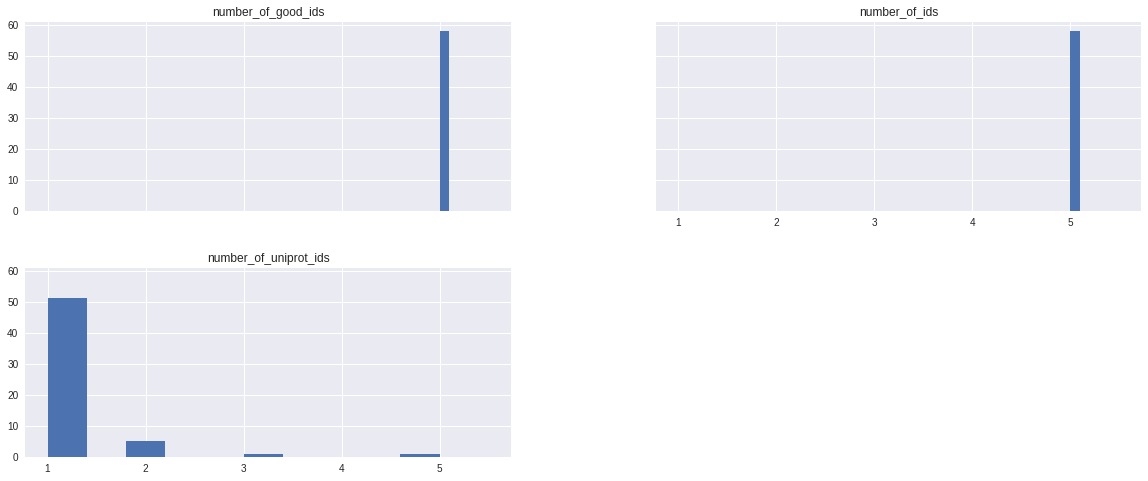

In [10]:
clusters.hist(figsize=(20,8), sharey=True, sharex=True)

<h3>Frequency</h3>

<h4>Frequency of bioactivity type</h4>

In [11]:
all_bioact = chembl.find_all_bioact(good_ids, directory)
frequency_bioact = {}
for bioact in all_bioact:
    frequency_bioact[bioact] = 0

for uniprot_id in good_ids:
    f = os.path.join(directory, 'uniprot', 'chembl_%s.csv' % uniprot_id)
    data = pd.read_csv(f)
    for bioact in all_bioact:

        frequency_bioact[bioact] += (data['bioactivity_type'] == bioact).any()
        
for bioact in all_bioact:
    frequency_bioact[bioact] /= len(good_ids)

frequency_bioact = pd.DataFrame(frequency_bioact, index=['%']).T

In [12]:
frequency_bioact.sort_values(by='%', ascending=False, inplace=True)
frequency_bioact.head(10)

,%
IC50,0.741379
Ki,0.644828
Inhibition,0.634483
Kd,0.606897
Activity,0.544828
EC50,0.313793
Ratio,0.306897
Ratio IC50,0.293103
Km,0.282759
Selectivity,0.213793


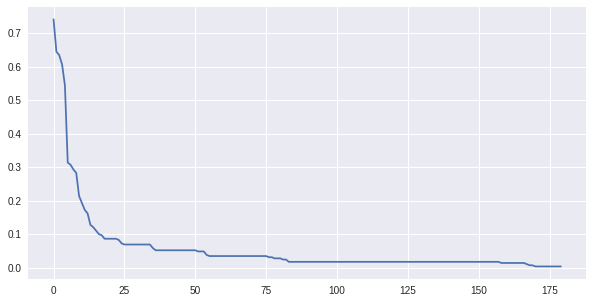

In [13]:
plt.figure(figsize=((10, 5)))
plt.plot(frequency_bioact['%'].values)

<h4>Frequency of units</h4>

In [14]:
all_units = chembl.find_all_units(good_ids, directory)
frequency_units = {}
for unit in all_units:
    frequency_units[unit] = 0

for uniprot_id in good_ids:
    f = os.path.join(directory, 'uniprot', 'chembl_%s.csv' % uniprot_id)
    data = pd.read_csv(f)
    for unit in all_units:
        frequency_units[unit] += (data['units'] == unit).any()
        
for unit in all_units:
    frequency_units[unit] /= len(good_ids)

frequency_units = pd.DataFrame(frequency_units, index=['%']).T

In [15]:
frequency_units.sort_values(by='%', ascending=False, inplace=True)
frequency_units.head(10)

,%
nM,0.793103
%,0.651724
Unspecified,0.486207
uM,0.482759
ug.mL-1,0.175862
degrees C,0.137931
s-1,0.137931
/M/s,0.086207
l M-1,0.086207
/s,0.086207


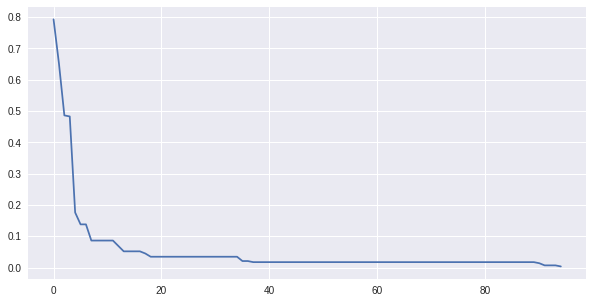

In [16]:
plt.figure(figsize=((10, 5)))
plt.plot(frequency_units['%'].values)

<h2>Data blopking</h2>

In [17]:
bioactives = ['IC50', 'Ki', 'Inhibition', 'Kd', 'Activity', 'EC50', 'Km', 'Ka', 'INH']
units = ['nM', '%']

In [18]:
for uniprot_id in good_ids:
    
    f = os.path.join(directory, 'uniprot', 'chembl_%s.csv' % uniprot_id)
    data = pd.read_csv(f)

    data = data.loc[data['smiles'] != 'Unspecified'] # drop Unspecified smiles
    
    data = data[data['bioactivity_type'].isin(bioactives)] # only chosen bioactivity types
        
    data = chembl.convert_units(data) # convert units

    data = data.loc[data['value'] >= 0 | (data['units'] != '%')]  # drop % < 0

    data = data[data['units'].isin(units)] # only chosen units


    # BLOP
    idx = data.index[((data['units'] == 'nM') & 
            (data['bioactivity_type'] == 'Activity')) | ((data['bioactivity_type'] == 'EC50') & 
                                                            (data['units'] == '%'))]
    data.drop(idx, inplace=True)
        
    data.drop_duplicates(inplace=True)

    data.to_csv(f, index=False)


In [19]:
def table_type_unit(uniprot_id, directory, all_act_type, all_units):

    f = os.path.join(directory, 'uniprot', 'chembl_%s.csv' % uniprot_id)
    if os.path.isfile(f):
        data = pd.read_csv(f)
        count = {}
        for act_type in all_act_type:
            count[act_type] = []
            query = data[data['bioactivity_type'] == act_type]
            for unit in all_units:
                count[act_type].append(sum(query['units'] == unit))

        return pd.DataFrame(count, index=all_units)
    

In [20]:
type_unit = sum([table_type_unit(uniprot_id, directory, bioactives, units) for uniprot_id in good_ids])
type_unit

,Activity,EC50,IC50,INH,Inhibition,Ka,Kd,Ki,Km
nM,0,27177,270342,520,0,311,10663,141007,592
%,16288,0,0,0,82746,0,0,0,0


In [21]:
pd.read_csv('/home/paulina/IBB/all/uniprot/chembl_A9JQL9.csv').head()

,uniprot_id,chembl_id,smiles,bioactivity_type,operator,value,units
0,A9JQL9,CHEMBL525377,Cc1ccc(cc1)c2ccc(CCCN(O)C(=O)CP(=O)(O)O)cc2,Ki,>,7000.0,nM
1,A9JQL9,CHEMBL495807,CC(=O)NP(=O)(O)OCCCc1cccc(Oc2ccccc2)c1,IC50,=,8.0,nM
2,A9JQL9,CHEMBL497815,OP(=O)(O)CC(=O)NCCCc1ccc(cc1)c2ccccc2,Ki,=,810.0,nM
3,A9JQL9,CHEMBL561057,CC(=CCC\C(=C\CNCCNC1C2CC3CC(CC1C3)C2)\C)C,IC50,=,100000.0,nM
4,A9JQL9,CHEMBL561057,CC(=CCC\C(=C\CNCCNC1C2CC3CC(CC1C3)C2)\C)C,Ki,=,360.0,nM


<h3>Make clusters</h3>

In [22]:
for cluster in set(data_pdb['cluster_id'].tolist()):
    idx = data_pdb.index[data_pdb['cluster_id'] == cluster]

    cluster_data = []
    for uniprot_id in set(data_pdb['uniprot_id'][idx]):
        f = os.path.join('/home/paulina/IBB/all/uniprot/', 'chembl_%s.csv' % uniprot_id)
        if os.path.isfile(f):
            cluster_data.append(pd.read_csv(f))
    if cluster_data:
        cluster_data = pd.concat(cluster_data)
        
        cluster_data.drop_duplicates(inplace=True)
        cluster_data.to_csv('/home/paulina/IBB/all/cluster/chembl_%s.csv' % cluster, index=False)
